# Challenges with Heterogeneity: Nonlinear Treatment Effects

## Table of Contents
1. [Intuition](#intuition)
2. [Formal Treatment](#formal)
3. [Numeric Demonstration](#numeric)
4. [Implementation](#implementation)
5. [Interview Appendix](#interview)
6. [References](#references)

---

**Chapter 23 | Notebook 2 of 2**

This notebook explores challenges when treatment effects vary with both
segment AND treatment level, using pricing elasticity as the key example.

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add parent to path for imports
module_path = str(Path.cwd().parent.parent)
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from facure_augment.common import *
set_notebook_style()

---

## 1. Intuition {#intuition}

### The Pricing Problem

**Scenario**: Streaming company (Netflix, HBO) wants to set prices.
- Run experiment with different price levels: 5, 10, 15, 20 BRL/month
- Measure sales/subscriptions
- Goal: Understand price sensitivity by customer segment

### The Complication

With **continuous treatment** (price), effects depend on:
1. Customer segment (who they are)
2. Treatment level (where on the curve)

This creates a 2D heterogeneity problem:

$$\frac{\partial Y}{\partial T} = f(X, T)$$

Not just:

$$\frac{\partial Y}{\partial T} = f(X)$$

> **Key insight**: "Who is more price-sensitive?" depends on the price range.

---

## 2. Formal Treatment {#formal}

### 2.1 Nonlinear Response Curves

General model:
$$Y = g(T, X) + \epsilon$$

If $g$ is nonlinear in $T$, the treatment effect varies:

$$\tau(t, x) = \frac{\partial g(t, x)}{\partial t}$$

### 2.2 The Ordering Problem

When comparing segments $A$ and $B$:

$$\tau_A(t_1) > \tau_B(t_1) \not\Rightarrow \tau_A(t_2) > \tau_B(t_2)$$

**Example**: Segment A at price 15 may have higher elasticity than 
Segment B at price 5, even if B is "more price-sensitive" overall.

### 2.3 Linearization

Transform treatment to make response linear:

$$Y = \alpha + \beta \cdot h(T) + \epsilon$$

where $h(\cdot)$ linearizes the relationship.

**Benefits**: Constant derivative → ranking independent of treatment level

**Drawbacks**: 
- May not be possible
- May discard business-relevant curvature
- Interpretation becomes harder

---

## 3. Numeric Demonstration {#numeric}

### Pricing Experiment Data

In [2]:
# Simulated pricing experiment results
# Two segments: A (high income), B (low income)
# Sales decrease with price, but nonlinearly

data = pd.DataFrame({
    'segment': ['B', 'B', 'B', 'B', 'A', 'A', 'A', 'A'],
    'price': [5, 10, 15, 20, 5, 10, 15, 20],
    'sales': [5100, 5000, 4500, 3000, 5350, 5300, 5000, 4500]
})

print("Pricing Experiment Results:")
print(data.pivot(index='price', columns='segment', values='sales'))

Pricing Experiment Results:
segment     A     B
price              
5        5350  5100
10       5300  5000
15       5000  4500
20       4500  3000


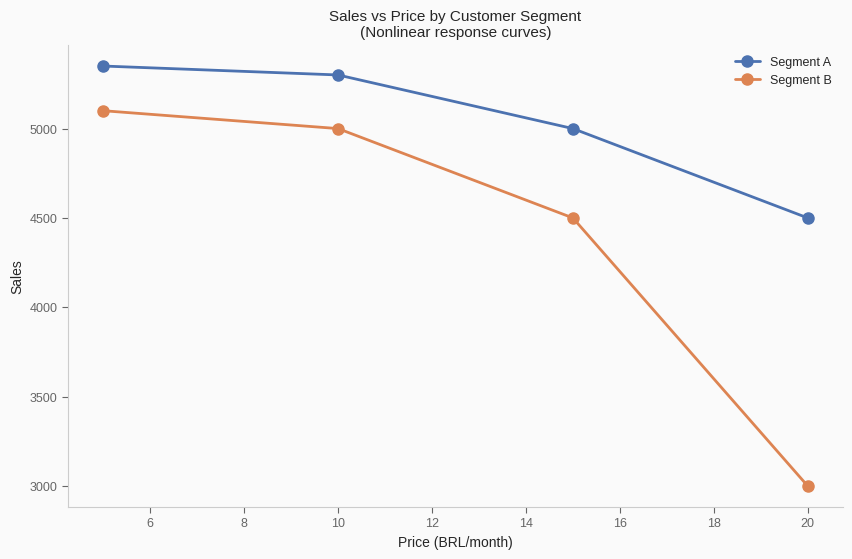

In [3]:
# Visualize the response curves
fig, ax = plt.subplots(figsize=(10, 6))

for segment, color in [('A', COLORS['blue']), ('B', COLORS['orange'])]:
    seg_data = data[data['segment'] == segment]
    ax.plot(seg_data['price'], seg_data['sales'], 'o-', 
            color=color, linewidth=2, markersize=8, label=f'Segment {segment}')

ax.set_xlabel('Price (BRL/month)')
ax.set_ylabel('Sales')
ax.set_title('Sales vs Price by Customer Segment\n(Nonlinear response curves)')
ax.legend()
apply_tufte_style(ax)
plt.show()

### Computing Treatment Effects

In [4]:
# Calculate price elasticities (treatment effects)
effects = []

for segment in ['A', 'B']:
    seg_data = data[data['segment'] == segment].sort_values('price')
    prices = seg_data['price'].values
    sales = seg_data['sales'].values
    
    for i in range(len(prices) - 1):
        delta_price = prices[i+1] - prices[i]
        delta_sales = sales[i+1] - sales[i]
        effect = delta_sales / delta_price  # Sales change per price unit
        
        effects.append({
            'segment': segment,
            'from_price': prices[i],
            'to_price': prices[i+1],
            'effect': effect,
            'midpoint': (prices[i] + prices[i+1]) / 2
        })

effects_df = pd.DataFrame(effects)
print("Price Elasticity (ΔSales / ΔPrice):")
print(effects_df.to_string(index=False))

Price Elasticity (ΔSales / ΔPrice):
segment  from_price  to_price    effect  midpoint
      A           5        10  -10.0000    7.5000
      A          10        15  -60.0000   12.5000
      A          15        20 -100.0000   17.5000
      B           5        10  -20.0000    7.5000
      B          10        15 -100.0000   12.5000
      B          15        20 -300.0000   17.5000


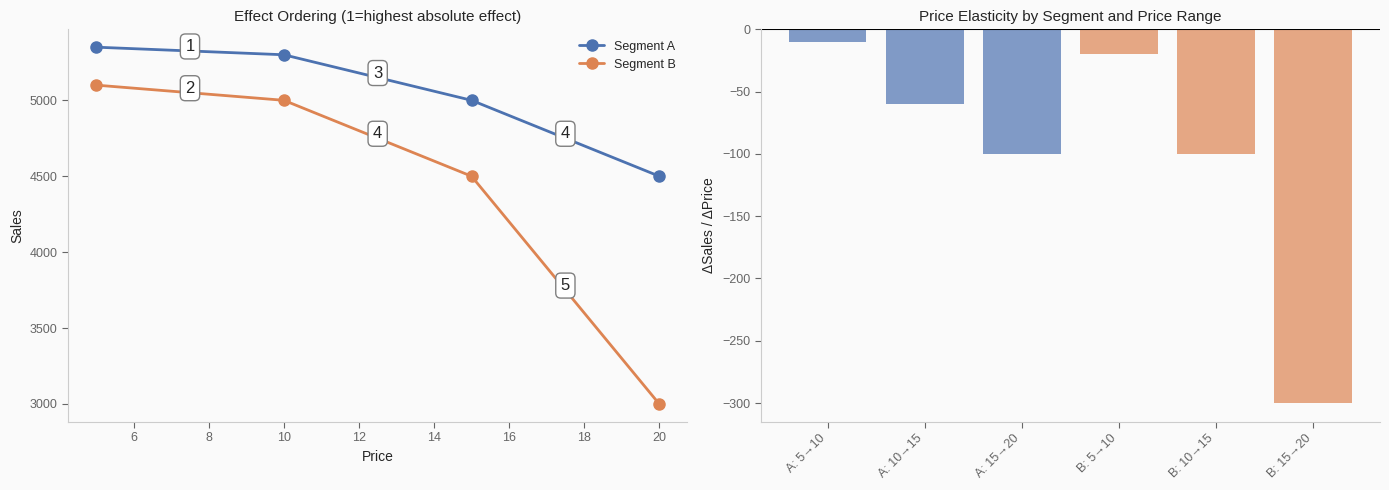

In [5]:
# Visualize the ordering problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Response curves with annotations
ax = axes[0]
for segment, color in [('A', COLORS['blue']), ('B', COLORS['orange'])]:
    seg_data = data[data['segment'] == segment]
    ax.plot(seg_data['price'], seg_data['sales'], 'o-', 
            color=color, linewidth=2, markersize=8, label=f'Segment {segment}')

# Annotate effect ordering (1 = highest absolute effect)
annotations = [
    (7.5, 5325, '1'),   # A: 5→10
    (7.5, 5050, '2'),   # B: 5→10
    (12.5, 5150, '3'),  # A: 10→15
    (12.5, 4750, '4'),  # B: 10→15
    (17.5, 4750, '4'),  # A: 15→20 (tie)
    (17.5, 3750, '5'),  # B: 15→20
]

for x, y, label in annotations:
    ax.annotate(label, (x, y), fontsize=12, 
                bbox=dict(boxstyle='round', fc='white', ec='gray'),
                ha='center')

ax.set_xlabel('Price')
ax.set_ylabel('Sales')
ax.set_title('Effect Ordering (1=highest absolute effect)')
ax.legend()
apply_tufte_style(ax)

# Bar chart of effects
ax = axes[1]
x = np.arange(len(effects_df))
colors = [COLORS['blue'] if s == 'A' else COLORS['orange'] for s in effects_df['segment']]
bars = ax.bar(x, effects_df['effect'], color=colors, alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([f"{row['segment']}: {row['from_price']}→{row['to_price']}" 
                    for _, row in effects_df.iterrows()], rotation=45, ha='right')
ax.set_ylabel('ΔSales / ΔPrice')
ax.set_title('Price Elasticity by Segment and Price Range')
ax.axhline(0, color='black', linestyle='-')
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

```
★ Insight ─────────────────────────────────────────────────────
The ordering of treatment effects depends on both:
1. **Who** (segment A vs B)
2. **Where** (price range 5→10 vs 15→20)

Example: A at 10→15 has higher absolute effect than B at 5→10!

This makes "who is more price-sensitive?" poorly defined
without specifying the price range.
──────────────────────────────────────────────────────────────
```

### The Incomplete Experiment Problem

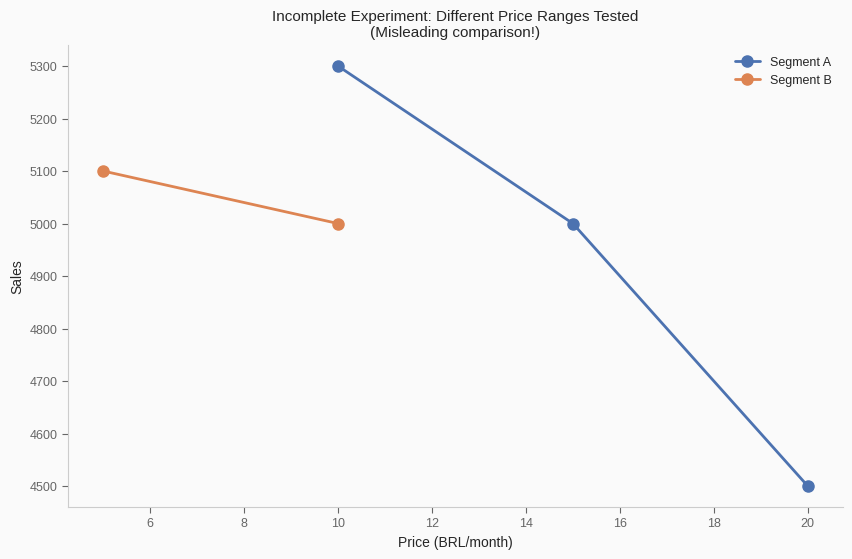

⚠️  With this data, segment A looks MUCH more price-sensitive!
   But that's only because we tested A in the high-elasticity region.


In [6]:
# What if we only tested different price ranges for each segment?
# Common in practice: test around "reasonable" prices per segment

# A: tested 10, 15, 20 (higher prices for rich segment)
# B: tested 5, 10 (lower prices for price-sensitive segment)

incomplete_data = data[
    ((data['segment'] == 'A') & (data['price'] >= 10)) |
    ((data['segment'] == 'B') & (data['price'] <= 10))
]

fig, ax = plt.subplots(figsize=(10, 6))

for segment, color in [('A', COLORS['blue']), ('B', COLORS['orange'])]:
    seg_data = incomplete_data[incomplete_data['segment'] == segment]
    ax.plot(seg_data['price'], seg_data['sales'], 'o-', 
            color=color, linewidth=2, markersize=8, label=f'Segment {segment}')

ax.set_xlabel('Price (BRL/month)')
ax.set_ylabel('Sales')
ax.set_title('Incomplete Experiment: Different Price Ranges Tested\n(Misleading comparison!)')
ax.legend()
apply_tufte_style(ax)
plt.show()

print("⚠️  With this data, segment A looks MUCH more price-sensitive!")
print("   But that's only because we tested A in the high-elasticity region.")

---

## 4. Implementation {#implementation}

### Linearization Attempt

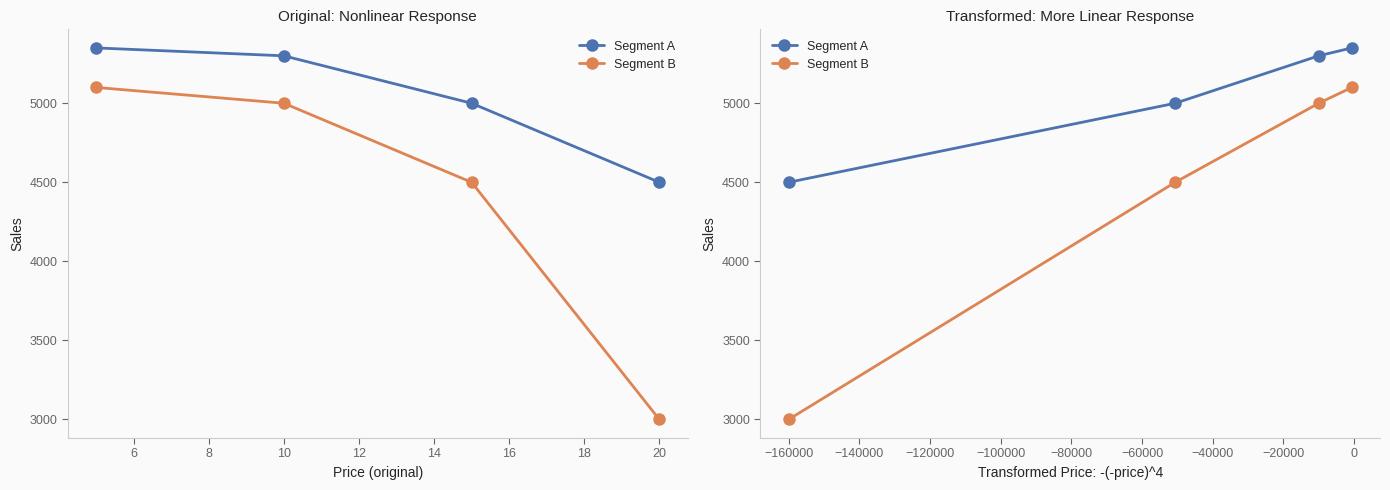

In [7]:
# Try to linearize by transforming price
# Experiment with different transformations

def transform_price(price, method='power4'):
    """Transform price to linearize response."""
    if method == 'power4':
        return -1 * (-price) ** 4  # Facure's suggestion
    elif method == 'log':
        return np.log(price)
    elif method == 'sqrt':
        return np.sqrt(price)
    else:
        return price

# Compare original vs transformed
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
ax = axes[0]
for segment, color in [('A', COLORS['blue']), ('B', COLORS['orange'])]:
    seg_data = data[data['segment'] == segment]
    ax.plot(seg_data['price'], seg_data['sales'], 'o-', 
            color=color, linewidth=2, markersize=8, label=f'Segment {segment}')
ax.set_xlabel('Price (original)')
ax.set_ylabel('Sales')
ax.set_title('Original: Nonlinear Response')
ax.legend()
apply_tufte_style(ax)

# Transformed
ax = axes[1]
for segment, color in [('A', COLORS['blue']), ('B', COLORS['orange'])]:
    seg_data = data[data['segment'] == segment].copy()
    seg_data['price_transformed'] = transform_price(seg_data['price'], 'power4')
    ax.plot(seg_data['price_transformed'], seg_data['sales'], 'o-', 
            color=color, linewidth=2, markersize=8, label=f'Segment {segment}')
ax.set_xlabel('Transformed Price: -(-price)^4')
ax.set_ylabel('Sales')
ax.set_title('Transformed: More Linear Response')
ax.legend()
apply_tufte_style(ax)

plt.tight_layout()
plt.show()

### Practical Guidelines

In [8]:
guidelines = pd.DataFrame({
    'Approach': [
        'Same treatment range',
        'Linearization',
        'Local effects',
        'Structural models'
    ],
    'Description': [
        'Test same prices for all segments',
        'Transform T or Y to make linear',
        'Compare only at same treatment level',
        'Fit parametric demand curve'
    ],
    'Pros': [
        'Direct comparison possible',
        'Constant derivative',
        'No extrapolation',
        'Full curve estimation'
    ],
    'Cons': [
        'May test unrealistic prices',
        'Harder to interpret',
        'Limited generalization',
        'Model misspecification risk'
    ]
})

print("Approaches for Nonlinear Treatment Effects:")
print(guidelines.to_string(index=False))

Approaches for Nonlinear Treatment Effects:
            Approach                          Description                       Pros                        Cons
Same treatment range    Test same prices for all segments Direct comparison possible May test unrealistic prices
       Linearization      Transform T or Y to make linear        Constant derivative         Harder to interpret
       Local effects Compare only at same treatment level           No extrapolation      Limited generalization
   Structural models          Fit parametric demand curve      Full curve estimation Model misspecification risk


```
★ Key Takeaway ────────────────────────────────────────────────
With continuous treatments and nonlinear responses:

1. **Be careful**: Effect rankings depend on treatment level
2. **Ensure comparability**: Same treatment range across segments
3. **Be skeptical**: Don't extrapolate beyond tested range
4. **Consider business needs**: Sometimes curvature matters!

Ask: "Do I care about effect at a specific level, or overall?"
──────────────────────────────────────────────────────────────
```

---

## 5. Interview Appendix {#interview}

### Q1: How does nonlinear treatment effect differ from binary outcome issues?

<details>
<summary>Solution</summary>

**Binary outcome** (notebook 01):
- Treatment effect varies with baseline OUTCOME level
- S-curve in P(Y=1)
- Solution: Target those near 50% baseline

**Nonlinear treatment** (this notebook):
- Treatment effect varies with TREATMENT level
- Curve in Y vs T
- Solution: Compare at same treatment level, or linearize

**Connection**: Both involve nonlinearity creating position-dependent derivatives.

**Combined case**: Binary outcome + continuous treatment = most complex!

</details>

### Q2: A pricing experiment shows Segment A more price-sensitive. Should we offer them discounts?

<details>
<summary>Solution</summary>

**Questions to ask**:
1. Were both segments tested at the same price range?
2. Is the response curve linear or nonlinear?
3. At what price point do we want to compare?

**Red flags**:
- Different price ranges tested → misleading comparison
- Strong curvature → effect depends on current price
- Extrapolation beyond tested range

**Recommendation**:
- Ensure overlap in tested prices
- Compare at specific price points
- Consider full demand curve estimation

</details>

### Q3: When should you linearize vs accept nonlinearity?

<details>
<summary>Solution</summary>

**Linearize when**:
- Goal is ranking segments by overall sensitivity
- Business decision doesn't depend on specific level
- Curvature is "accidental" (not business-relevant)

**Accept nonlinearity when**:
- Curvature is business-relevant (e.g., demand saturation)
- Different actions planned at different levels
- Linearization loses important information

**Example**:
- If deciding "who gets ANY discount": linearize
- If deciding "who gets 10% vs 20% discount": keep nonlinearity

</details>

---

## 6. References {#references}

[^1]: Fernández-Loría, C., & Provost, F. (2022). Causal Classification: Treatment Effect Estimation 
      vs. Outcome Prediction. *Journal of Machine Learning Research*.

[^2]: Varian, H. R. (2014). Big Data: New Tricks for Econometrics. *Journal of Economic 
      Perspectives*, 28(2), 3-28.

[^3]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 23.